In [33]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.plotly as py
import plotly.tools as tls
from plotly import tools
import colorlover as cl
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import math
import warnings
import json
import importlib
from functions_git import *
from functions_git import indexInsurance

warnings.filterwarnings("ignore")
# Sign in to Plotly just in case
py.sign_in('Travissius', 'T6tcb5OjAqBgiHxTnOxH')

In [35]:
def indexInsurance(rasterpath, proj, actuarialyear, startyear, endyear, baselineyear, baselinendyear,  productivity, strike, acres, allocation, adjustit, standardizeit, indexit = True, method = 1, difference = 0):
    """
    **** UNDER CONSTRUCTION AND OPEN TO SUGGESTION ****

        Takes in a list of raster paths and variables, namely a drought index of some sort and 
            uses them to calculate hypothetical Pasture, Rangeland, and Forage Insurance payouts for 
            each Risk Management Agency (RMA) grid cell for each interval between a range of years.
        
        
        ARGUMENTS:                      DESCRIPTION                                                 OBJECT              
                                                                                                    TYPE
            
            rasterpath               - Path to list of alternate climate files for index            (rasters)
            startyear                - Start year for the payout calculation                        (integer)
            baselineyear             - Year back to which the monthly average values will be        (integer)
                                          indexed (if needed)
            maskpath                 - Path to a mask of the CONUS for indices with the 
                                            the Great Lakes, Cananda, or Mexico                     (raster)
            gridpath                 - Path to the USDA Risk Management Agency Grid                 (raster)
            actuarial                - Path to folder with all actuarial arrays                     (rasters)
            productivity             - Number signifying productivity ratio                         (float)
            strike                   - Number signifying gaurantee level that triggers payouts      (float)
            acres                    - Number of acres per cell                                     (integer)
            allocation               - Monthly Allocation                                           (float)
            adjusted                 - True if the data is already binned into 11 intervals         (boolean)
            standardized             - True if the scale needs no min/max standardization           (boolean)
                                       (This might be important for certain drought indices)
            indexed                  - True if the climate variable is already normalized to        (boolean)
                                           its baseline values
            
        
        RETURNS:
            
            insurance_package_all
                totalsubsidies       - List of total subsidy values in every interval/year          (list of arrays)
                producerpremiums     - List of producer premium values in every interval/year       (list of arrays)
                indemnities          - List of indemnity values in every interval/year              (list of arrays)
                
            insurance_pacakge_average 
                meansubsidy          - Average 'monthly' total subsidies for each grid cell         (array)
                meanppremium         - Average 'monthly' producer premiums for each grid cell       (array)
                meanindemnity        - Average 'monthly' indemnity for each grid cell               (array)
    
        THINGS TO DO/Consider:

            1) Add in a try/except structure for errors
    
            2) Some stipulations on calculating new indices
                a) The RMA is calculated from 1948 up to two years before the crop year, though the
                    baseline years may be changed to check for effects
                b) Most drought indices are already indexed to local conditions, though it is 
                    possible to reindex them with the method used by the RMA. 
                c) There are multiple methods of calculation to compensate for various index value
                    distributions. Be careful to choose the appropriate standardization and indexing
                    options for each index. 
                d) So far this is only functional for grazing operations, actuarial rates for 
                    haying are available but need to be rasterized before they can be used here.
                    
            3) Simplify the parameters:
                a) actuarial paths can be coded in for the github package. I can set the option
                    for which year more simply this way. 
                b) the methodology can be simplified by removing the cryptic method numbers and 
                    setting the interval adjustment standardization and indexing options to 
                    positive statements. 
                c) the return options can be changed to intuitive strings as well;
                        'payouts',netpayouts','lossratios'
                        
            3) Insurable interest is apparently included in the original cacluation, what is this 
                    and how do I incorporate it?
                    
    **** UNDER CONSTRUCTION ****
    
    """    
    ###########################################################################
    ############## Establish some necessary pieces to the calculation #########
    ###########################################################################
    # This dictionary of column names is needed to match information from the actuarial rates to 
        # the appropriate place and time. At the 
    colnames1 = {'Grid ID':'gridid','Guarantee Level':'strike','Grazing Interval\n Jan-Feb':'g1',\
    'Grazing Interval\n Feb-Mar':'g2', 'Grazing Interval\n Mar-Apr':'g3','Grazing Interval\n Apr-May':'g4',\
    'Grazing Interval\n May-Jun':'g5','Grazing Interval\n Jun-Jul':'g6','Grazing Interval\n Jul-Aug':'g7',\
    'Grazing Interval\n Aug-Sep':'g8','Grazing Interval\n Sep-Oct':'g9','Grazing Interval\n Oct-Nov':'g10',\
    'Grazing Interval\n Nov-Dec':'g11','Haying Interval (non-irrigated)\n Jan-Feb':'h1',\
    'Haying Interval (non-irrigated)\n Feb-Mar':'h2', 'Haying Interval (non-irrigated)\n Mar-Apr':'h3',\
    'Haying Interval (non-irrigated)\n Apr-May':'h4', 'Haying Interval (non-irrigated)\n May-Jun':'h5',\
    'Haying Interval (non-irrigated)\n Jun-Jul':'h6', 'Haying Interval (non-irrigated)\n Jul-Aug':'h7',\
    'Haying Interval (non-irrigated)\n Aug-Sep':'h8','Haying Interval (non-irrigated)\n Sep-Oct':'h9',\
    'Haying Interval (non-irrigated)\n Oct-Nov':'h10','Haying Interval (non-irrigated)\n Nov-Dec':'h11',\
    'Haying Interval (irrigated)\n Jan-Feb':'h1','Haying Interval (irrigated)\n Feb-Mar':'h2', \
    'Haying Interval (irrigated)\n Mar-Apr':'h3','Haying Interval (irrigated)\n Apr-May':'h4', \
    'Haying Interval (irrigated)\n May-Jun':'h5','Haying Interval (irrigated)\n Jun-Jul':'h6', \
    'Haying Interval (irrigated)\n Jul-Aug':'h7','Haying Interval (irrigated)\n Aug-Sep':'h8',\
    'Haying Interval (irrigated)\n Sep-Oct':'h9','Haying Interval (irrigated)\n Oct-Nov':'h10',\
    'Haying Interval (irrigated)\n Nov-Dec':'h11'}
    colnames2 = {y:x for x,y in colnames1.items()} # This is backwards to link simplified column 
                                                         # names to get the original ones. 
        
    ###########################################################################
    ############## Getting all the numbers ####################################
    ###########################################################################    
    # Read in the mask to display only the Contiguous United States
    mask = readRaster('data\\masks\\'+proj+'\\mask4.tif',1,-9999.)[0]
        
    # This is the NOAA generated .25 by .25 degree grid of CONUS that the RMA uses 
    grid = readRaster('data\\rma\\'+proj+'\\prfgrid.tif',1,-9999.)[0]
    
    # Actuarial rate paths -- to be simplified
    if actuarialyear == 2017:
        actuarialpath = 'data\\actuarial\\2017\\rasters\\'+proj+'\\'
    elif actuarialyear == 2018:
        actuarialpath = 'data\\actuarial\\2018\\rasters\\'+proj+'\\'
    premiumpath = actuarialpath+'premiums'
    basepath = actuarialpath+'bases\\rates'
    allocationminpath = actuarialpath+'bases\\allocations\\min'
    allocationmaxpath = actuarialpath+'bases\\allocations\\max'

    # The premiums and base values are now in raster form, so we just need to convert to arrays
    premiums = readRasters2(premiumpath,-9999.)[0] #[0] because we can use the original geometry to write these to rasters.     
    bases = readRasters2(basepath,-9999.)[0]     
    
    ####!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!##########
    ################ not incorporated yet #####################################
    ###########!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#########
    # Allocation limits typically range from .1 to .6 
    allocmins = readRasters2(allocationminpath,-9999.)[0]
    allocmaxs = readRasters2(allocationmaxpath,-9999.)[0] 
    
    ###########################################################################
    ############## Adjust the Climate Index list if Needed ####################
    ###########################################################################     
    # Load in the test index -  The geometry and projection are there for writing rasters 
    [indexlist,indexgeo,indexproj] = readRasters(rasterpath,-9999.)  
    indexlist = [[index[0],index[1]*mask] for index in indexlist]   
    indexname = indexlist[0][0][:-7]
    
    # Original Categories (more or less)
    NOAAkey = {.9: .9,
               .85: .85,
               .8: .8,
               .75: .75,
               .7: .7}
    PDSIkey = {.9: -.5 ,
               .85: -1,
               .8: -2,
               .75: -3,
               .7: -4}
    SPIkey = {.9: -.25 ,
           .85: -.5,
           .8: -1,
           .75: -1.5,
           .7: -2}
    
    # Method one will recreate the method used in the PRF for the rain data. It will adjust to 11 
    # intervals by combining each two month period and averaging them. Then it will standardize
    # the values based on the minimum and maximum from the entire period and extent. Then it 
    # will index these values using average monthly values for each pixel over the period 
    # available. Any of these steps can be skipped using function arguments if needed.  
    
    if method == 1:
        key = NOAAkey
        if adjustit == True:
            indexlist = adjustIntervals(indexlist)
    
        if standardizeit == True:      
            arrays = [indexlist[i][1] for i in range(len(indexlist))]
            amin = np.nanmin(arrays)
            amax = np.nanmax(arrays)
            indexlist = standardize(indexlist,amin,amax)
            
        if indexit == True:            
            indexlist = normalize(indexlist,baselineyear,baselinendyear)            


    # Because drought indices are already indexed, here is a second method for calculating payouts.
        # Instead of stanardizing and indexing based on average monthly values the payment 
        # calculation factor will be made using the index values directly.     
        # Next are results from various methods of determining corresponding drought index values to 
        # the 5 different strike levels. -- to be simplified/ removed
        
#    if method == 2:
#        if adjust== True:
#            indexlist = adjustIntervals(indexlist)
#        if indexname == "NOAA":
#            key = NOAAkey
#        if indexname[0:4] == "PDSI":
#            key = PDSIkey
#        if indexname[0:2] == "SP":
#            key = SPIkey
#        if indexname[0:4] == "EDDI":
#            key = EDDIkey
#            
    # Categories of matching probability -- because the pre-existing drought categories came with 
        # low probabilities of occurrence. This matches the likelihood of strike with that of the 
        # corresponding strike of the RMA index -- to be simplified
    if method == 2:
        if adjustit == True:
            indexlist = adjustIntervals(indexlist)
            categorypath = 'data\\Index Categories\\indexcategories-original.csv'

        if standardizeit == True:      
            arrays = [indexlist[i][1] for i in range(len(indexlist))]
            amin = np.nanmin(arrays)
            amax = np.nanmax(arrays)
            indexlist = standardize(indexlist,amin,amax)
            categorypath = 'data\\Index Categories\\indexcategories-standardized.csv'

        if indexit == True:            
            indexlist = normalize(indexlist,baselineyear,baselinendyear)      
            categorypath = 'data\\Index Categories\\indexcategories-reindexed.csv'

        strikedf = pd.read_csv(categorypath)
        rmafield = [float(str(round(l,2))) for l in strikedf['RMA']]
        dfield = [float(str(round(l,2))) for l in strikedf[indexname]]
        key = dict(zip(rmafield,dfield))
            
    # Now reduce the list to the calculation period.
    indexlist = [year for year in indexlist if int(year[0][-6:-2]) >= startyear and int(year[0][-6:-2]) <= endyear]
    
    ###########################################################################
    ############## Call the function to get array lists  ######################
    ###########################################################################
    #totalsubsidyarrays = [insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask)[0] for array in indexlist]
    totalpremiums = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[3]] for array in indexlist]
    producerpremiums = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[1]] for array in indexlist]
    indemnities = [[array[0],insuranceCalc(array, productivity,strike,acres,allocation,bases,premiums,mask,key,method)[2]] for array in indexlist]
    
    totalpremiumarrays =  [element[1] for element in totalpremiums]
    premiumarrays = [element[1] for element in producerpremiums]
    indemnityarrays = [element[1] for element in indemnities]
    
    ###########################################################################
    ############## Call the function to get frequencies #######################
    ###########################################################################
    def freqCalc(array,strike):
        strike2 = key.get(strike)
        array[array<=strike2] = -9999
        array[array>strike2] = 0
        array[array == -9999] = 1
        return(array)    
    
    copylist = [[array[0],np.copy(array[1])] for array in indexlist]
    frequencyrays = [freqCalc(array[1],strike) for array in copylist]
    frequencysum = np.sum(frequencyrays,axis = 0)
    frequencies = [[indexlist[i][0],frequencyrays[i]] for i in range(len(frequencyrays))]
    
    ###########################################################################
    ############## Same for Payout Claculation Factors ########################
    ###########################################################################
    # The Payment Calculation Factor is the step that adjusts the payout amount proportional 
        # to the degree of deficit severity. This might be the most useful output.
        # Lower index values result in higher PCF values (more money)
        
    def pcfCalc(array,strike):
        array[array>strike] = 0
        strike2 = key.get(strike) # Strike2 to preserve the original strike value
        pcf = abs((strike2-array)/strike2)
        pcf[pcf == 1] = 0
        return(pcf)
    
    copylist = [[array[0],np.copy(array[1])] for array in indexlist]
    pcfrays = [pcfCalc(array[1],strike) for array in copylist]
    meanpcf = np.nanmean(pcfrays,axis = 0)
    pcfs = [[indexlist[i][0],pcfrays[i]] for i in range(len(pcfrays))]

    ###########################################################################
    ############## Average the out comes to show mean values at each cell #####
    ###########################################################################
    meanppremium = np.nanmean(premiumarrays,axis=0)
    meanindemnity = np.nanmean(indemnityarrays,axis=0)
    meantpremium = np.nanmean(totalpremiumarrays,axis = 0)
    
    # Use those to get net payments and loss ratios
    net = meanindemnity - meanppremium
    nets = [[indemnities[i][0],indemnityarrays[i] - premiumarrays[i]] for i in range(len(indemnityarrays))]
    lossratio = np.round(meanindemnity/meantpremium,2)
    lossratios = [[indemnities[i][0],indemnityarrays[i] / premiumarrays[i]] for i in range(len(indemnityarrays))]
    
    ###########################################################################
    ################### We have to print and plot before returning ############
    ###########################################################################
    print('######################### Amount Results #######################')
    print(indexname+" Payout Statistics \nMax Payout: ", round(np.nanmax(meanindemnity),2),
          "\nMinimum Payout: ", round(np.nanmin(meanindemnity),2),
          "\nMedian Payout: ", round(np.nanmedian(meanindemnity),2),
          "\nMean Payout: ", round(np.nanmean(meanindemnity),2),
          "\nPayout Standard Deviation: ",round(np.nanstd(meanindemnity),2))
    print('######################### Results ##############################')
    
    ################### Average Indemnity/ Net Pay Map  #######################
    if difference == 0:
        mainmap = meanindemnity
        series1 = indemnities
        ylimit = 5000
        title = "Potential Payouts"
        title2 = "Average: $" + str(round(np.nanmean(meanindemnity),2))
        label = 'Potential Payouts USD ($)'
    elif difference == 1:
        mainmap = net
        series1 = nets
        ylimit = 5000
        title = "Potential Net Pay"
        title2 = "Bi-Monthly Average: $" + str(round(np.nanmean(net),2))
        label = 'Potential Net Pay USD ($)'
    elif difference == 2:
        mainmap = lossratio
        series1 = lossratios
        ylimit = 5
        title = "Loss Ratios"
        title2 = "US average: " + str(round(np.nanmean(lossratio),2))
        label = 'Loss Ratio'
        
    ################### Read in Shapefile #####################################
    # It will possible to overlay adiministrative boundaries in the future
    #    usa = shp.Reader(path+'USAContiguous.shp')
    #        
    #    plt.figure()
    #    for shape in usa.shapeRecords():
        #        x = [i[0] for i in shape.shape.points[:]]
        #        y = [i[1] for i in shape.shape.points[:]]
        #        plt.plot(x,y)
        #    plt.show()   
    
    ################### Plot everything  ######################################
    try:
    # Main Title
        fig = plt.figure(figsize=(35, 20))
        if startyear == endyear:
            endyear = ""
        else:
            endyear = ' - '+str(endyear)
        fig.suptitle('PRF with '+indexname+": "+str(startyear)+endyear+'\nBaseline year: '+str(baselineyear)+'; Strike Level: %'+ str(int(strike*100))+'; Rate Year: '+str(actuarialyear), fontsize=12,fontweight = 'bold')
             
        # Establish subplot structure
        ax1 = plt.subplot2grid((3, 4), (0, 0), colspan = 2)
        ax2 = plt.subplot2grid((3, 4), (0, 2), colspan = 2)  
        ax3 = plt.subplot2grid((3, 4), (1, 0), colspan = 3,rowspan = 2)    
        ax4 = plt.subplot2grid((3, 4), (1, 3), colspan = 1,rowspan = 2) 
#        fig.subplots_adjust(top=0.82,bottom=0.07,left=0.06,right=0.9,hspace=0.4,wspace=0.25)
#        fig.tight_layout(pad=3, h_pad=3, w_pad=3)
        # Set initial plot 4 parameters - this is an interactive barplot
        ax4.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off')
#        ax4.set_title('Monthly Trends')
         
        # Plot 1 - Payout Frequency Distribution
        im = ax1.imshow(frequencysum.tolist())
        ax1.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
        ax1.set_title('US average: '+str(round(np.nanmean(frequencysum),2)))#Payment Frequency\n 
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("left", size="5%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax1)
        cbar.set_label('Potential Payouts', rotation=90, size = 10,labelpad =10,fontweight = 'bold')
        cbar.ax.yaxis.set_label_position('left')
        cbar.ax.yaxis.set_ticks_position('left')
    
        # Plot 2 - Payment Calculation Factor Distribution
        im2 = ax2.imshow(meanpcf.tolist())
        ax2.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
        ax2.set_title('US average: '+str(round(np.nanmean(meanpcf),3)))# Payment Calculation Factors\n  
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="5%", pad=0.05)
        cbar2 = plt.colorbar(im2, cax=cax2)
        cbar2.set_label('Payment Calculation\n Factor', rotation=270, size = 10,labelpad =25,fontweight = 'bold')
          
        # Plot 3- Changes
        im3 = ax3.imshow(mainmap.tolist())
        ax3.tick_params(which='both',right = 'off',left = 'off', bottom='off', top='off',labelleft = 'off',labelbottom='off') 
        ax3.set_title(title2)#title + '\n'+ 
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes("left", size="5%", pad=0.05)
        cbar3 = plt.colorbar(im3, cax=cax3)
        cbar3.set_label(label, rotation=90, size = 12,labelpad =10,fontweight = 'bold')
        cbar3.ax.yaxis.set_label_position('left')
        cbar3.ax.yaxis.set_ticks_position('left')
    
        # shift subplots down a bit
        fig.subplots_adjust(top=.85)  
        
    
        ###########################################################################   
        ############# Interactive Monthly Payout Trends ###########################
        ###########################################################################
        # Define click event        
        coords = []
        def onclick(event):
            global ix, iy
            ix, iy = event.xdata, event.ydata
            #print('x = %d, y = %d'%(ix, iy)) # This is just for testing
        
            global coords
            coords.append((ix, iy))
            
            if event.inaxes == ax1: 
                calctype = 'Sum '
                ax = ax1
                series = frequencies
                ylim = 12
                xlabel = 'Year'
                rot = -45
                bartitle = "Potential Payouts"
                pointtype = 'yo'
                col = 'yellow'
                print ("event in ax1")
                yearly = 1
            elif event.inaxes == ax2:
                calctype = 'Average '
                ax = ax2            
                bartitle = "Mean pcfs"            
                rot = -45
                series = pcfs
                ylim = 1
                xlabel = 'Bi-Monthly Interval'
                pointtype = 'ro'
                col = 'red'
                print ("event in ax2")  
                yearly = 0
            elif event.inaxes == ax3:
                calctype = 'Average '
                ax = ax3
                bartitle = title
                rot = -45
                series = series1            
                pointtype = 'wo'
                ylim = ylimit
                xlabel = 'Bi-Monthly Interval'
                col = 'white'
                print ("event in ax3") 
                yearly = 0
        #         Colors:   'b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'
        
            # Catch the target grid cell
            targetid  = grid[round(float(iy)),round(float(ix))]
            index = np.where(grid == targetid)
    
            # Create the time series of data at that gridcell
            timeseries = [[item[0],item[1][index]] for item in series]
            
            # For title
            years = [int(item[0][-6:-2]) for item in timeseries]
            year1 = str(min(years)) 
            year2 = str(max(years))
            
            # For the x axis and value matching
            intervals = [format(int(interval),'02d') for interval in range(1,12)]
            months = {1:'Jan-Feb',
                      2:'Feb-Mar',
                      3:'Mar-Apr',
                      4:'Apr-May',
                      5:'May-Jun',
                      6:'Jun-Jul',
                      7:'Jul-Aug',
                      8:'Aug-Sep',
                      9:'Sep-Oct',
                      10:'Oct-Nov',
                      11:'Nov-Dec'}
            
            # The actual values
            valuelist = [[series[1] for series in timeseries if series[0][-2:] ==  interval] for interval in intervals]
        
            # In tuple form for the bar chart
            averages =  tuple(np.asarray([np.mean(sublist) for sublist in valuelist]))
            intlabels = tuple([months.get(i) for i in range(1,12)])
            x = np.arange(len(intervals))    
            
            # A yearly series of sums for the frequency box
            if yearly == 1:
                timeseries = [[item[0],item[1][index]] for item in series]
               
                # For title
                years = [int(item[0][-6:-2]) for item in timeseries]
                year1 = str(min(years)) 
                year2 = str(max(years))
               
                # For the x axis and value matching
                intervals = [str(interval) for interval in range(int(year1),int(year2)+1)]
               
                # The actual values
                valuelist = [[series[1] for series in timeseries if series[0][-6:-2] ==  interval] for interval in intervals]
               
                # In tuple form for the bar chart            
                axisinterval= round((int(year2)-int(year1))/10)
                averages =  tuple(np.asarray([np.nansum(sublist) for sublist in valuelist]))
                intlabels = tuple([interval for interval in range(int(year1),int(year2)+1,axisinterval)])
                x = np.arange(len(intervals))
        
            
            # For adding a spot to the map
            spot = np.where(grid == targetid)
            
            # Clears data but not axes
            ax4.cla()  
        
            # Plot the bar chart
            ax4.tick_params(which='both',right = 'on',left = 'off', bottom='on', top='off',labelleft = 'off',labelright = 'on',labelbottom='on')
            ax4.yaxis.set_label_position("right")
            ax4.bar(x,averages, align='center', alpha=0.5,color = col,linewidth = 2,edgecolor = 'black')
            ax4.set_ylabel(calctype + bartitle, rotation=270, labelpad=15,fontweight = 'bold')
            ax4.set_ylim([0, ylim])
            ax4.set_title('Grid ID: '+str(int(targetid)))
            if yearly == 1: 
                ax4.set_xticks([])
                ax4.set_xticks(np.arange(1,len(intervals)+1,axisinterval),minor = True)
                ax4.set_xticklabels([])
                ax4.set_xticklabels(intlabels, rotation = rot, ha="left",fontsize=12, minor = True)
                ax4.set_xlabel(xlabel)
            else:
                ax4.set_xticks(np.arange(len(intervals)))
                ax4.set_xticklabels(intlabels, rotation = rot, ha="left",fontsize=12)
                ax4.set_xlabel(xlabel)
    
            # Add spot to map
            point = ax.plot(int(spot[1]),int(spot[0]),pointtype, markersize=6,markeredgewidth=1, markeredgecolor='k')#, edgecolor='black',linewidth='1'
            
            # Draw it all
            #cfm = fig.get_current_fig_manager()
            #cfm.frame.Maximize(True)
            fig.canvas.draw()
            
            return coords
        global cid
        cid = fig.canvas.mpl_connect('button_press_event', onclick)
    except:
        PrintException()
    ###########################################################################
    ############## Bundle up the results for a tidy return ####################
    ###########################################################################
    insurance_package_all = [producerpremiums,indemnities]
    insurance_package_average = [meanppremium,meanindemnity]
    index_package_all = [frequencyrays,pcfrays]
    index_package = [frequencysum,meanpcf]
    return([insurance_package_all,insurance_package_average,index_package_all,index_package,cid,coords])

In [10]:
# Get all of the color codes
for name, hex in matplotlib.colors.cnames.items():
    print(name, hex)
print("\n Color Scales\n")
print(
['Blackbody',
'Bluered',
'Blues',
'Earth',
'Electric',
'Greens',
'Greys',
'Hot',
'Jet',
'Picnic',
'Portland',
'Rainbow',
'RdBu',
'Reds',
'Viridis',
'YlGnBu',
'YlOrRd'])

aliceblue #F0F8FF
antiquewhite #FAEBD7
aqua #00FFFF
aquamarine #7FFFD4
azure #F0FFFF
beige #F5F5DC
bisque #FFE4C4
black #000000
blanchedalmond #FFEBCD
blue #0000FF
blueviolet #8A2BE2
brown #A52A2A
burlywood #DEB887
cadetblue #5F9EA0
chartreuse #7FFF00
chocolate #D2691E
coral #FF7F50
cornflowerblue #6495ED
cornsilk #FFF8DC
crimson #DC143C
cyan #00FFFF
darkblue #00008B
darkcyan #008B8B
darkgoldenrod #B8860B
darkgray #A9A9A9
darkgreen #006400
darkgrey #A9A9A9
darkkhaki #BDB76B
darkmagenta #8B008B
darkolivegreen #556B2F
darkorange #FF8C00
darkorchid #9932CC
darkred #8B0000
darksalmon #E9967A
darkseagreen #8FBC8F
darkslateblue #483D8B
darkslategray #2F4F4F
darkslategrey #2F4F4F
darkturquoise #00CED1
darkviolet #9400D3
deeppink #FF1493
deepskyblue #00BFFF
dimgray #696969
dimgrey #696969
dodgerblue #1E90FF
firebrick #B22222
floralwhite #FFFAF0
forestgreen #228B22
fuchsia #FF00FF
gainsboro #DCDCDC
ghostwhite #F8F8FF
gold #FFD700
goldenrod #DAA520
gray #808080
green #008000
greenyellow #ADFF2F


Converting raster to numpy array...


100%|██████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 1495.90it/s]


######################### Amount Results #######################
SPEI-6 Payout Statistics 
Max Payout:  1152.27 
Minimum Payout:  32.21 
Median Payout:  216.47 
Mean Payout:  255.47 
Payout Standard Deviation:  146.59
######################### Results ##############################


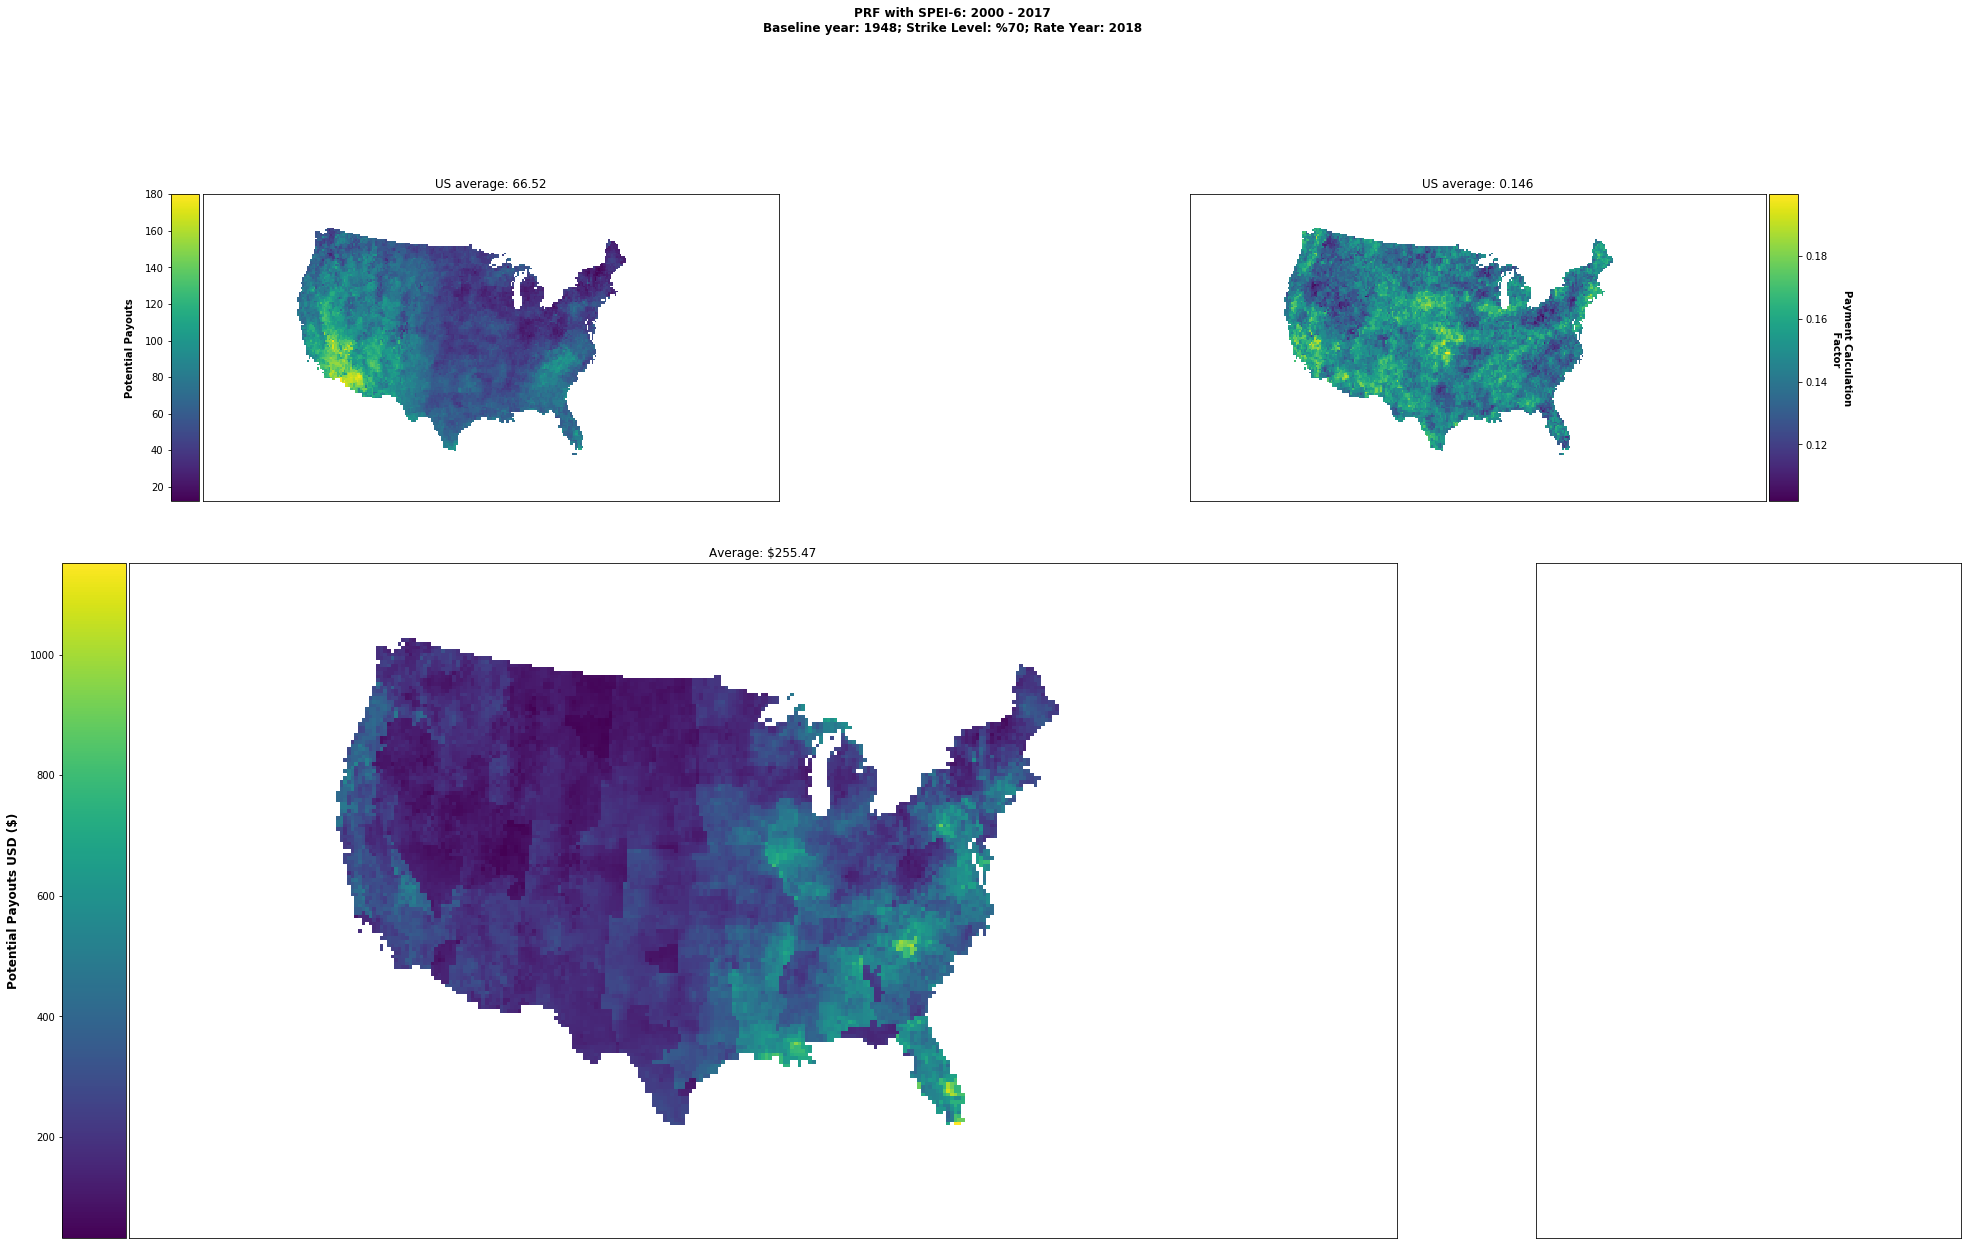

In [36]:

####################### Test methods for drought indices ######################
#rasterpath = r'e:\data\droughtindices\palmer\pdsi\nad83'
rasterpath = r'd:\data\droughtindices\spei\albers\6month'
#rasterpath = r'E:\data\droughtindices\grace\nad83\rz\monthly\quarteres'
method = 2 # method 2 set strike levels based on matching probability of occurrence with the RMA index
adjustit = True
standardizeit = True
indexit = False

############### Argument Definitions ##########################################
proj = 'albers'
actuarialyear = 2018 
baselineyear = 1948
baselinendyear = 2016   
startyear = 2000
endyear = 2017
productivity = 1 
strike = .7
acres = 500
allocation = .5
difference = 0 # 0 = i
[insurance_package_all, 
 insurance_package_average, 
 index_package_all,
 index_package,
 cid,coords] = indexInsurance(rasterpath, proj, actuarialyear, startyear,endyear, baselineyear,
                              baselinendyear, productivity, strike, acres, allocation, 
                              adjustit = adjustit,standardizeit = standardizeit, indexit = indexit, 
                              method = method, difference = difference) 


In [37]:
# Extract Desired Return Information
# Return order:
#insurance_package_all = [producerpremiums,indemnities]
#insurance_package_average = [meanppremium,meanindemnity]
#index_package_all = [frequencyrays,pcfrays]
#index_package = [frequencysum,meanpcf]
frequency = index_package[0]
pcf = index_package[1]
indemnities = insurance_package_average[1]

In [39]:
import plotly.graph_objs as go
app = dash.Dash()

colors = {
    'background': '#87CEEB',
    'text': ' #8B4513'
}

app.layout = html.Div(children=[
    
    # Title- first child
    html.H1('Pasture, Rangeland, and Forage:', style={'textAlign': 'center', 'color': '#7FDFF'}),
    
    # Subtitle - second child
    html.H2('Alternate Index Experiment', style={'textAlign': 'center', 'color': '#7FDFF'}),
    
    # First Graph - Payout Frequencies
    html.Div([dcc.Graph(id='heatmap1',
                        figure={'data': [{'z': np.flip(frequency,axis = 0),
                                'colorscale':'Greens',
                                'colorbar':dict(x = -.15, y=.85,len=.4),
                                'zmin':0,'zmax':200,
                                'type': 'heatmap'}],
                                    'layout' : {'margin':{'l': 50, 'b': 10, 't': 10, 'r': 50},
                                                'legend':{'x': 0, 'y': 200},
                                                'hovermode':'closest',
                                                'yaxis':{'title':'Payment Calculation Factor'}}})],
                        style={'display': 'inline-block'}),
    
    # Second Graph - Payment Calculation Factors
    html.Div([dcc.Graph(id='heatmap2',
                        figure={'data': [{'z': np.flip(pcf,axis = 0),
                                'colorscale':'YlGnBu',
                                'colorbar':dict(x = 1, y=.85,len=.4),
                                'zmin':0,'zmax':.4,
                                'type': 'heatmap'}],
                                    'layout' : {'margin':{'l': 50, 'b': 40, 't': 10, 'r': 10},
                                                'legend':{'x': 0, 'y': 200},
                                                'hovermode':'closest',
                                                'yaxis':{'title':'Payment Calculation Factor'}}})],
                        style={'display': 'inline-block'}),
    
    # Third Graph - Mean Payouts
    html.Div([dcc.Graph(id='heatmap3',
                        figure={'data': [{'z': np.flip(indemnities,axis = 0),
                                'colorscale':'Earth',
                                'colorbar':dict(x = -.15, y=.85,len=.4),
                                'zmin':0,'zmax':1200,
                                'type': 'heatmap'}],
                                    'layout' : {'margin':{'l': 40, 'b': 40, 't': 10, 'r': 10},
                                                'legend':{'x': 0, 'y': 200},
                                                'hovermode':'closest',
                                                'yaxis':{'title':'Payment Calculation Factor'}}})],
                        style={'display': 'inline-block'}),
    
    # Dropdown Label - sixth child
    html.Label('Drought Indices'),
    
    # Dropdown Menu - seventh child
    dcc.Dropdown(options=[{'label': 'EDDI-6', 'value': 'D:\\data\\droughtindices\\eddi\\nad83\\monthly\\6month'},
            {'label': 'SPEI-6', 'value': 'D:\\data\\droughtindices\\spei\\nad83\\6month'},
            {'label': 'PDSI', 'value': 'D:\\data\\droughtindices\\palmer\\pdsi\\nad83'}],value='PDSI'),
    
    
   # html.Div(id='output'),
])







if __name__ == '__main__':
    app.run_server()

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Mar/2018 14:05:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2018 14:05:25] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [09/Mar/2018 14:05:25] "GET /_dash-dependencies HTTP/1.1" 200 -


In [47]:
np.nanmax(indemnities)

1152.2707421083453